# Reconstructing The Stochastic Gates Algorithm
---
### Geometry of Information Course - Milestone #2 

**Made by**:<br>
[Aviv Gelfand](https://www.linkedin.com/in/aviv-gelfand/v) <br>
[Jonathan Wiesenfeld](https://il.linkedin.com/in/jonathan-wiesenfeld)

**Lectured by:** [Prof. Ariel Jaffe](https://arieljaffe.huji.ac.il/) 


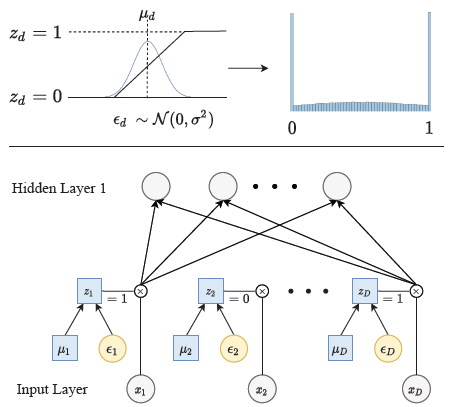
---

In this notebook, we apply the Stochastic Gates (STG) algorithm to both simulated and imported datasets to evaluate its efficacy in feature selection, through regression and classification tasks.

### Installing dependencies

In [2]:
# %pip install scikit-learn
# %pip install pandas
# %pip install seaborn
# %pip install torch
# %pip install stg 
# %pip install matplotlibv

# Regression

## `sin_dataset`

We employ the STG algorithm, configured for regression tasks, with a neural network architecture comprising hidden layers with dimensions [500, 50, 10] and tanh activation. The model utilizes SGD optimization, a learning rate of 0.1, and feature selection enabled to discern the most relevant features influencing the regression outcome. The training process involves 3000 epochs with validation on a subset to monitor performance and prevent overfitting.

In [3]:
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
### Helper function to save and compare regression metrics 

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import pandas as pd


## Sin_Dataset

The dataset comprises two input features, 'x1' and 'x2', and one output feature 'y'. 'x1' and 'x2' are random values between 1 and 5. 'y' is calculated as the sine of 'x1' multiplied by the cube of the cosine of 'x2'. Additional noise, sampled from a normal distribution with mean 0 and standard deviation 1, is added to the dataset, resulting in 'n' rows and 'p' columns. The first two columns represent 'x1' and 'x2', while the remaining columns contain noise variables.

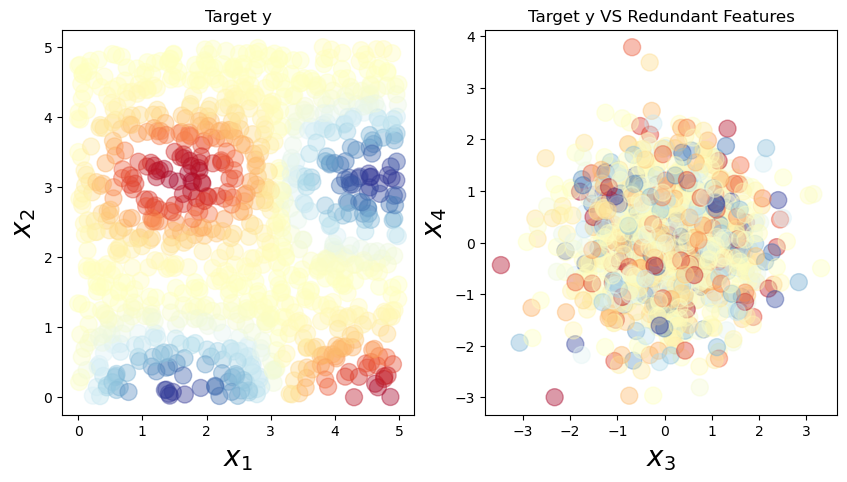

In [4]:
import warnings
warnings.filterwarnings('ignore')
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Create a simple dataset
def create_sin_dataset(n,p):
    x1=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    x2=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    y=np.sin(x1)*np.cos(x2)**3
    relevant=np.hstack((x1,x2))
    noise_vector = scipy.stats.norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y.astype(np.float32)

n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_sin_dataset(n_size,p_size)
# print(X_data.shape)
# print(y_data.shape)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 2], y=X_data[:, 3], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_3$', fontsize=20)
ax[1].set_ylabel('$x_4$', fontsize=20)
ax[1].set_title('Target y VS Redundant Features')
plt.tick_params(labelsize=10)


It can be observed that the target y is a non-linear function of the $X_1$ and $X_2$ features only.

Visual representation of the target variable y and the model's regression output on the synthetic dataset highlights the model's predictive accuracy and the non-linear relationship captured between the selected features and the target variable. This approach not only demonstrates the STG algorithm's potential in handling complex, noisy data but also its capability in feature selection and enhancing model interoperability.

Epoch: 1000: loss=0.149752 valid_loss=0.101698
Epoch: 2000: loss=0.060491 valid_loss=0.019841
Epoch: 3000: loss=0.035679 valid_loss=0.006965


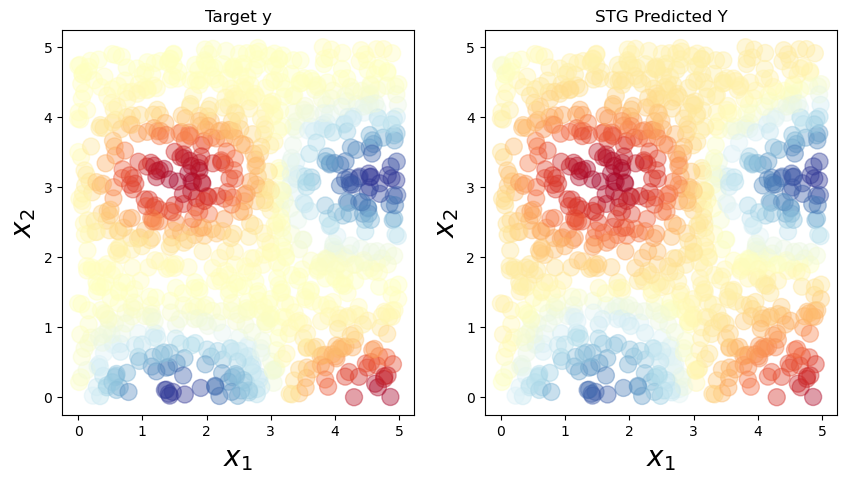

In [5]:
import warnings
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, random_state=42)


args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True
model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)

model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)

import torch
tmp_loss = torch.nn.MSELoss()
tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

tmp_loss(torch.Tensor(y_test), torch.Tensor(model.predict(X_test)))

model.get_gates(mode='prob')

model.get_gates(mode='raw')


## TESTING THE MODEL

y_pred=model.predict(X_data)
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('STG Predicted Y')
plt.tick_params(labelsize=10)
plt.show()


In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

p_size_ls = [3,4,5, 10, 20,50]
rmse_arr = []
sin_results_dict = {}
for p in p_size_ls:
    print(f"p={p}")
    n_size = 1000  # Number of samples
    X_data, y_data = create_sin_dataset(n_size, p)
    # Rest of the code from the previous cell
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8)

    args_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if args_cuda else "cpu")
    feature_selection = True
    model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[100, 50, 10], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)
    print("fitting model")
    model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)


    ## TESTING THE MODEL
    y_pred=model.predict(X_test)
    rmse_arr.append(np.sqrt(np.mean((y_pred - y_test)**2)))
    sin_results_dict[p] = {
            'R2 Score': round(r2_score(y_test, y_pred),3),
            'RMSE': round(mean_squared_error(y_test, y_pred, squared=False),3),
            'MAE': round(mean_absolute_error(y_test, y_pred),3),
            'MAPE': round(mean_absolute_percentage_error(y_test, y_pred),3),
            'gates_found': model.get_gates(mode='prob').astype(str),
        }
    
results_df_sin = pd.DataFrame(sin_results_dict).T


p=3
fitting model
Epoch: 1000: loss=0.140265 valid_loss=0.161142
Epoch: 2000: loss=0.138153 valid_loss=0.161142
Epoch: 3000: loss=0.137789 valid_loss=0.161142
p=4
fitting model
Epoch: 1000: loss=0.171056 valid_loss=0.142070
Epoch: 2000: loss=0.165455 valid_loss=0.144502
Epoch: 3000: loss=0.164735 valid_loss=0.144501
p=5
fitting model
Epoch: 1000: loss=0.175109 valid_loss=0.151952
Epoch: 2000: loss=0.165588 valid_loss=0.151944
Epoch: 3000: loss=0.164390 valid_loss=0.151748
p=10
fitting model
Epoch: 1000: loss=0.183951 valid_loss=0.113282
Epoch: 2000: loss=0.066696 valid_loss=0.044931
Epoch: 3000: loss=0.050861 valid_loss=0.031076
p=20
fitting model
Epoch: 1000: loss=0.160901 valid_loss=0.091539
Epoch: 2000: loss=0.079445 valid_loss=0.034606
Epoch: 3000: loss=0.048449 valid_loss=0.019700
p=50
fitting model
Epoch: 1000: loss=0.172343 valid_loss=0.094776
Epoch: 2000: loss=0.103892 valid_loss=0.043682
Epoch: 3000: loss=0.085457 valid_loss=0.023482


In [7]:
results_df_sin

,R2 Score,RMSE,MAE,MAPE,gates_found
3,-0.001,0.401,0.264,442.273987,"[0.0, 0.0, 0.0]"
4,-0.062,0.38,0.25,21712.947266,"[0.0, 0.0, 0.0, 0.0]"
5,-0.004,0.39,0.259,14478.601562,"[0.0, 0.0, 0.0, 0.0, 0.0]"
10,0.805,0.176,0.14,116.625,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,0.866,0.14,0.115,414.511993,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,0.847,0.153,0.119,6250.938965,"[1.0, 1.0, 0.18101117, 0.23164746, 0.27022028,..."


As shown in the above plot, the model successfully managed predict the correct output.

## Predicting Song Popularity 

In this task, we will use a sample of 150K records, out of the "Spotify Dataset 1921-2020, 600k+ Tracks.

### Columns:
* `popularity` - **Target Column** (Ranges from 0 to 100), float, representing the popularity of the song in the Spotify platform.
* `id` (Id of tracks generated by Spotify)
* `acousticness` (Ranges from 0 to 1)
* `danceability` (Ranges from 0 to 1)
* `energy` (Ranges from 0 to 1)
* `duration_ms` (Integer typically ranging from 200k to 300k)
* `instrumentalness` (Ranges from 0 to 1)
* `valence` (Ranges from 0 to 1)
* `animality` (Ranges from 0 to 1)
* `tempo` (Float typically ranging from 50 to 150)
* `liveness` (Ranges from 0 to 1)
* `loudness` (Float typically ranging from -60 to 0)
* `speechiness` (Ranges from 0 to 1)
* `release_year` a column which we are going to extract out of the Release column and predict based on song's features.
* `explicit` (Whether the song is explicit (contains swearing or inappropriate language) or not)
The following categorical columns will be removed to simplify the task (to many categories):



In [8]:
import pandas as pd
reg_url = 'https://raw.githubusercontent.com/FreeDataSets/DataPool/main/tracks_150000.csv' # this is the url for the dataset
reg_df = pd.read_csv(reg_url)#.sample(100000,random_state=42) # In order to reduce the size of the dataset, we are taking a random sample of 5000 rows from the dataset
reg_df.drop(['name', 'artists','id','release_date', 'artists_id','genre',], axis=1, inplace=True, errors='ignore') # Removing Categorical features with more then 10 unique values
reg_df.sample(1000,random_state=42)
# a preview of the dataframe
reg_df.info() 
display(reg_df.head())

p_size_ls = [3,5,10,13]
spot_results_dict = {}
for p in p_size_ls:

    # split the data into features and target variable 
    Xreg = reg_df.drop('popularity', axis=1).values[:,:p-1] # features
    yreg = reg_df['popularity'] # target variable

    from sklearn.model_selection import train_test_split
    # split the data into train and test sets
    Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(Xreg, yreg, test_size=0.2, random_state=42)

    from sklearn.preprocessing import StandardScaler
    scaler_reg = StandardScaler().fit(Xreg_train)
    Xreg_train_scaled = scaler_reg.transform(Xreg_train)
    Xreg_test_scaled = scaler_reg.transform(Xreg_test)

    # Define model parameters
    args_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if args_cuda else "cpu")

    model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[100, 50, 10], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)
    print("fitting model")
    model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)


    ## TESTING THE MODEL
    y_pred=model.predict(X_test)
    spot_results_dict[p] = {
            'R2 Score': round(r2_score(y_test, y_pred),3),
            'RMSE': round(mean_squared_error(y_test, y_pred, squared=False),3),
            'MAE': round(mean_absolute_error(y_test, y_pred),3),
            'MAPE': round(mean_absolute_percentage_error(y_test, y_pred),3),
            'gates_found': model.get_gates(mode='prob').astype(str),
        }
        
spot_results_dict = pd.DataFrame(spot_results_dict).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        150000 non-null  int64  
 1   duration_ms       150000 non-null  int64  
 2   explicit          150000 non-null  int64  
 3   danceability      150000 non-null  float64
 4   energy            150000 non-null  float64
 5   key               150000 non-null  int64  
 6   loudness          150000 non-null  float64
 7   speechiness       150000 non-null  float64
 8   acousticness      150000 non-null  float64
 9   instrumentalness  150000 non-null  float64
 10  liveness          150000 non-null  float64
 11  valence           150000 non-null  float64
 12  tempo             150000 non-null  float64
 13  time_signature    150000 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 16.0 MB


,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,25,219907,0,0.673,0.282,7,-14.247,0.0428,0.454,0.000000,0.118,0.549,126.041,4
1,0,181427,0,0.520,0.359,0,-11.863,0.0817,0.988,0.000000,0.106,0.861,89.963,4
2,8,181560,0,0.654,0.312,8,-17.238,0.0305,0.662,0.598000,0.106,0.526,95.032,4
3,50,166333,0,0.247,0.426,0,-7.775,0.0316,0.725,0.000000,0.160,0.253,178.251,4
4,31,191000,0,0.663,0.844,7,-4.548,0.0528,0.080,0.000005,0.176,0.911,168.093,4


fitting model
Epoch: 1000: loss=0.206745 valid_loss=0.144085
Epoch: 2000: loss=0.111058 valid_loss=0.050080
Epoch: 3000: loss=0.105882 valid_loss=0.053150
fitting model
Epoch: 1000: loss=0.202420 valid_loss=0.138458
Epoch: 2000: loss=0.114452 valid_loss=0.044564
Epoch: 3000: loss=0.084096 valid_loss=0.024032
fitting model
Epoch: 1000: loss=0.212737 valid_loss=0.149909
Epoch: 2000: loss=0.118120 valid_loss=0.050827
Epoch: 3000: loss=0.103585 valid_loss=0.043357
fitting model
Epoch: 1000: loss=0.209457 valid_loss=0.145840
Epoch: 2000: loss=0.118559 valid_loss=0.051298
Epoch: 3000: loss=0.099548 valid_loss=0.035741


In [9]:
spot_results_dict

,R2 Score,RMSE,MAE,MAPE,gates_found
3,0.654,0.231,0.181,18612.765625,"[1.0, 1.0, 0.1666531, 0.21930012, 0.31989032, ..."
5,0.844,0.155,0.121,6914.458008,"[1.0, 1.0, 0.20202464, 0.21643454, 0.2586901, ..."
10,0.718,0.208,0.167,23169.261719,"[1.0, 1.0, 0.17168427, 0.23069614, 0.28482693,..."
13,0.767,0.189,0.145,16009.888672,"[1.0, 1.0, 0.23669025, 0.27257872, 0.27019173,..."


# Classification

## UCI Madelon Dataset 

MADELON is an artificial dataset, which was part of the NIPS 2003 feature selection challenge. This is a two-class classification problem with continuous input variables. The difficulty is that the problem is multivariate and highly non-linear.

In [10]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
madelon = pd.read_csv('madelon.csv')

# Split the data into features and target
X = madelon.drop('Class', axis=1).values
y = madelon['Class'].values

# Convert labels from 1, 2 to 0, 1 for PyTorch compatibility
y = y - 1

# Ensure there are no invalid (e.g., negative) values
if np.any(y < 0):
    print("Found unexpected negative values in the target variable.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model parameters
args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True


metrics_dict = {'P_features':[],'accuracy': [],'f1':[], 'precision': [], 'recall': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}

k_values = [10, 100, 200, 500]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
import pandas as pd
for k in k_values:
    # Select the k first columns of the model
    X_train_k = X_train[:, :k]
    X_test_k = X_test[:, :k]
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit on the training data
    scaler.fit(X_train)

    # Transform both the training and testing data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Initialize and fit the model
    model = STG(task_type='classification',input_dim=X_train_k.shape[1],output_dim=2,hidden_dims=[500, 50, 10],activation='tanh',optimizer='SGD',learning_rate=0.1,batch_size=32,feature_selection=feature_selection,sigma=0.5,lam=0.1,random_state=1,device=device)
    # Fit the model
    model.fit(X_train_k, y_train, nr_epochs=100, valid_X=X_test_k, valid_y=y_test, print_interval=1000)

    # Create test predictions
    y_pred_k = model.predict(X_test_k)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred_k)
    # Extract the values from the confusion matrix
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    # Add metrics to metrics_dict
    metrics_dict['P_features'].append(k)
    metrics_dict['accuracy'].append(accuracy_score(y_test, y_pred_k))
    metrics_dict['f1'].append(f1_score(y_test, y_pred_k))
    metrics_dict['precision'].append(precision_score(y_test, y_pred_k))
    metrics_dict['recall'].append(recall_score(y_test, y_pred_k))
    # Append the values to the metrics_dict
    metrics_dict['tp'].append(tp)
    metrics_dict['tn'].append(tn)
    metrics_dict['fp'].append(fp)
    metrics_dict['fn'].append(fn)

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('P_features', inplace=True)

In [11]:
metrics_df


,accuracy,f1,precision,recall,tp,tn,fp,fn
P_features,,,,,,,,
10,0.494231,0.000000,0.000000,0.000000,0,257,0,263
100,0.532692,0.535373,0.538462,0.532319,140,137,120,123
200,0.528846,0.531549,0.534615,0.528517,139,136,121,124
500,0.561538,0.568182,0.566038,0.570342,150,142,115,113


## Two Moons Data Set
he function create_twomoon_dataset generates a synthetic dataset with two moon-shaped clusters commonly used for binary classification. It creates 'n' data samples with 'p' features. The relevant features and target labels are generated using the make_moons function from scikit-learn. Noise is added to the dataset using a normal distribution with mean 0 and standard deviation 1. Finally, the relevant features and noise are concatenated to form the dataset.

In [12]:
from stg import STG
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons
import torch

import numpy as np
from scipy.stats import norm

# Create a simple dataset
def create_twomoon_dataset(n, p):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
    noise_vector = norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y

n_size = 500 # Number of samples
p_size_ls = [5, 10, 20, 50]
acc_arr = []
metrics_dict = {'P_features':[],'accuracy': [],'f1':[], 'precision': [], 'recall': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}

for p in p_size_ls:
    
    X_data, y_data=create_twomoon_dataset(n_size,p_size)
    y_data= y_data.astype(float)

    print(f"p={p}")
    n_size = 1000  # Number of samples
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8)
    # y_train = torch.squeeze(y_train)
    # y_test = torch.squeeze(y_test)
    args_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if args_cuda else "cpu")
    feature_selection = True
    model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=1, device=device) 

    model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)

    # tmp_loss = torch.nn.MSELoss()
    # tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

    # model.get_gates(mode='prob')

    # model.get_gates(mode='raw')


    ## TESTING THE MODEL

        
    # Create test predictions
    y_pred_k = model.predict(X_test)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred_k)
    # Extract the values from the confusion matrix
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    # Add metrics to metrics_dict
    metrics_dict['P_features'].append(p)
    metrics_dict['accuracy'].append(accuracy_score(y_test, y_pred_k))
    metrics_dict['f1'].append(f1_score(y_test, y_pred_k))
    metrics_dict['precision'].append(precision_score(y_test, y_pred_k))
    metrics_dict['recall'].append(recall_score(y_test, y_pred_k))
    # Append the values to the metrics_dict
    metrics_dict['tp'].append(tp)
    metrics_dict['tn'].append(tn)
    metrics_dict['fp'].append(fp)
    metrics_dict['fn'].append(fn)

metrics_df_moons = pd.DataFrame(metrics_dict)
metrics_df_moons.set_index('P_features', inplace=True)

p=5
Epoch: 1000: loss=0.328295 valid_loss=0.332646
Epoch: 2000: loss=0.128342 valid_loss=0.089422
Epoch: 3000: loss=0.067695 valid_loss=0.015184
p=10
Epoch: 1000: loss=0.344069 valid_loss=0.208763
Epoch: 2000: loss=0.092055 valid_loss=0.028829
Epoch: 3000: loss=0.069390 valid_loss=0.009808
p=20
Epoch: 1000: loss=0.318571 valid_loss=0.295053
Epoch: 2000: loss=0.124610 valid_loss=0.070146
Epoch: 3000: loss=0.069232 valid_loss=0.010947
p=50
Epoch: 1000: loss=0.339740 valid_loss=0.244356
Epoch: 2000: loss=0.134402 valid_loss=0.064398
Epoch: 3000: loss=0.071869 valid_loss=0.012234


In [13]:
metrics_df_moons

,accuracy,f1,precision,recall,tp,tn,fp,fn
P_features,,,,,,,,
5,1.000,1.000000,1.000000,1.0,54,46,0,0
10,1.000,1.000000,1.000000,1.0,91,109,0,0
20,1.000,1.000000,1.000000,1.0,94,106,0,0
50,0.995,0.995169,0.990385,1.0,103,96,1,0


Looks like the algorithm did not struggle at all here either.